In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

from cofactor.features import Features
from cofactor.model import LatticePredictor
from cofactor.calculator import CofactorCalculator

In [14]:
featgen = Features.from_excel('data/elemental.xlsx')
model = LatticePredictor.from_file('models/model.pkl')
data = pd.read_csv('data/lattices.csv', index_col=0)
properties = pd.read_excel('data/labels.xlsx', index_col=0)
elements = pd.read_excel('data/element_labels.xlsx', index_col=0)

## Plotting solubility

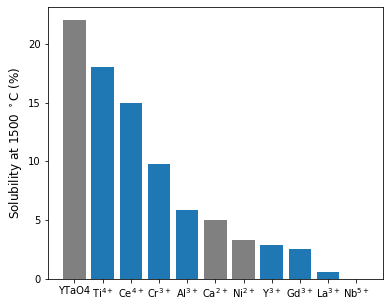

In [5]:
fig, ax = plt.subplots(figsize=(6, 5))
el = (elements
    .drop(['Hf', 'Zr'])
    .sort_values('solubility', ascending=False)
)

el['color'] = el.index.map(
    lambda x: (0x1f / 255, 0x77 / 255, 0xb4 / 255, 1) if x in ['Ti', 'Ce', 'Cr', 'Al', 'Y', 'Gd', 'La']
    else (0x80 / 255, 0x80 / 255, 0x80 / 255, 1)
)

ax.bar(el.label, el.solubility, color=el.color)
ax.set_ylabel(r'Solubility at 1500 $^\circ$C (%)', fontsize=12)
fig.savefig('figs/solubility.pdf')
plt.show()


## Plotting properties

In [6]:
def features_from_df(df, element, n_samples=101):
    df['T0'] = df['T0 (K)'] - 273
    df['Ms'] = df['Ms (K)'] - 273
    df['x'] = to_mol_percent(df, element)
    df = interpolate_df(df, n_samples)
    
    
    inputs = {
        element: df.x.values.reshape(-1, 1),
        'Zr': 1 - df.x.values.reshape(-1, 1),
        'T': df.T0.values.reshape(-1, 1),
        'Ms': df.Ms.values.reshape(-1, 1),
        'hyst': (df.T0 - df.Ms).values.reshape(-1, 1),
    }
    X = featgen.get_features(inputs, model.features)
    
    return X

def interpolate_df(df, n_samples=101):
    new_index = np.linspace(df.x.min(), df.x.max(), n_samples)
    new_index = np.unique(np.concatenate([new_index, df.x]))
    df = df.set_index('x').reindex(new_index).interpolate(method='index').reset_index()
    return df

def get_cofactors(X, model):
    cofactors = []
    dV = []
    for tetr, mono in model.predict_lattice(X[model.features]):
        calc = CofactorCalculator(tetr, mono)
        cofactors.append(calc.get_cofactors())
        dV.append(calc.get_volume_change())

    return pd.concat([
        X,
        pd.DataFrame(cofactors),
        (pd.DataFrame(dV) - 1) * 100
    ], axis=1)

def get_gradient(results, element, prop1, prop2):
    grad_dilute = results[[element, prop1, prop2]][:2].diff().iloc[-1]
    
    dP1_dx = grad_dilute[prop1] / (100 * grad_dilute[element])
    dP2_dx = grad_dilute[prop2] / (100 * grad_dilute[element])
    
    return dP1_dx, dP2_dx

# def to_mol_percent(df, element):
#     x = df.iloc[:, 0] / 100

#     s = df.columns[0]
#     num = re.findall(element + '(\d)O', s)
#     if len(num) == 0:
#         return x

#     return x / (int(num[0]) - x)

def to_mol_percent(df, element):
    x = df.iloc[:, 0] / 100

    s = df.columns[0]
    num = re.findall(element + '(\d)O', s)
    if len(num) == 0:
        return x
    num = int(num[0])
#     return num * x / (1 + num * x)
    return num * x / (1 + x)

def to_mol_percent_ab(df, element):
    x = df.iloc[:, 0] / 100

    s = df.columns[0]
    a = re.findall(element + '(\d)O', s)
    b = re.findall('O(\d)', s)
    if len(a) == 0:
        a = [1]
    
    if len(b) == 0:
        b = [1]
    
    a, b = int(a[0]), int(b[0])
    
    return 100 * a * x / (3 - (a + b - 3) * x)

### Design charts

In [7]:
UNCERTAINTY_LAMBDA = 0.001145

ELEMENT_STR = {
    'Al': r'Al$^{3+}$',
    'Ca': r'Ca$^{2+}$',
    'Ce': r'Ce$^{4+}$',
    'Cr': r'Cr$^{3+}$',
    'Gd': r'Gd$^{3+}$',
    'Hf': r'Hf$^{4+}$',
    'La': r'La$^{3+}$',
    'Ti': r'Ti$^{4+}$',
    'Y': r'Y$^{3+}$',
    'Zr': r'Zr$^{4+}$',
}

PROP_LABEL = {
    'B_lambda': r'\lambda_2',
    'Ms': r'M_s',
    'hyst': r'(T_0 - M_s)',
    'B_dV': r'\Delta V',
}
PROP_UNIT = {
    'B_lambda': '1',
    'Ms': r'$^\circ$C',
    'hyst': '$^\circ$C',
    'B_dV': r'%'
}

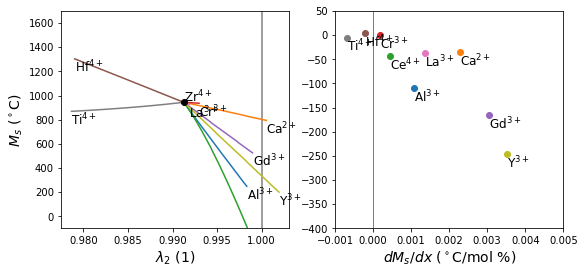

TypeError: cannot convert the series to <class 'float'>

<Figure size 648x288 with 2 Axes>

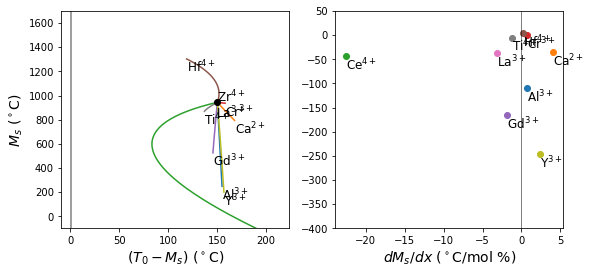

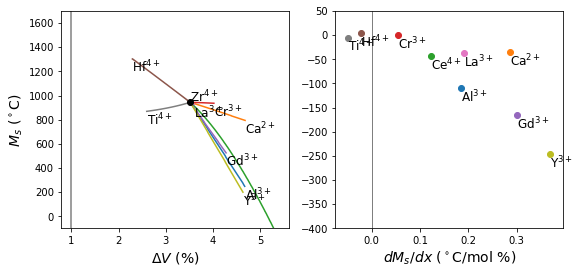

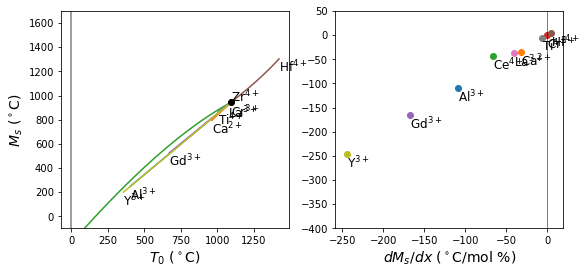

In [78]:
YAXIS_PROP = 'Ms'
yprop = properties.loc[YAXIS_PROP]

for prop, xprop in properties.iterrows():
    
    files = sorted(os.listdir('data/t0'))
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))

    for file in files:
        element = file.strip('.csv')
        df = pd.read_csv(os.path.join('data/t0', file))
        X = features_from_df(df, element)
        results = get_cofactors(X, model)
        results = results.sort_values(element)
        
        el_labels = elements.loc[element]
        results = results[results[element] < (el_labels['solubility'] / 100)]

        ax[0].plot(results[prop], results[YAXIS_PROP], label=element)
        ax[0].annotate(el_labels['label'], (results[prop].values[-1], results[YAXIS_PROP].values[-1]), fontsize=12, va='top')

        dX, dY = get_gradient(results, element, prop, YAXIS_PROP)
        ax[1].scatter(dX, dY)
        ax[1].annotate(el_labels['label'], (dX, dY), fontsize=12, va='top')

    ax[0].scatter([results[prop].values[0]], [results[YAXIS_PROP].values[0]], zorder=3, color='k')
    ax[0].annotate(elements.loc['Zr', 'label'], (results[prop].values[0], results[YAXIS_PROP].values[0]), fontsize=12)

    ax[0].set_xlabel('$%s$ (%s)' % (xprop['label'], xprop['unit']), fontsize=14)
    ax[0].set_ylabel('$%s$ (%s)' % (yprop['label'], yprop['unit']), fontsize=14)

    ylim = (-100, 1700)
    ax[0].set_ylim(ylim)
    ax[0].plot([1, 1], ylim, color='#808080', zorder=-1)

    ax[1].set_xlabel('$d%s/dx$ (%s/mol %%)' % (xprop['label'], xprop['unit']), fontsize=14)
    ax[1].set_xlabel('$d%s/dx$ (%s/mol %%)' % (yprop['label'], yprop['unit']), fontsize=14)

    ylim1 = [-400, 50]
    ax[1].plot([0, 0], ylim1, color='k', linewidth=0.5)
    ax[1].set_ylim(ylim1)
    
    if prop == 'B_lambda':
        ax[1].set_xlim(-0.001, 0.005)
    
    # ax.legend()
#     fig.tight_layout()
    plt.show()

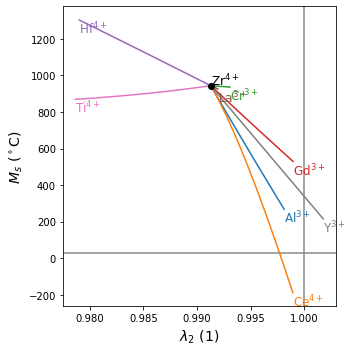

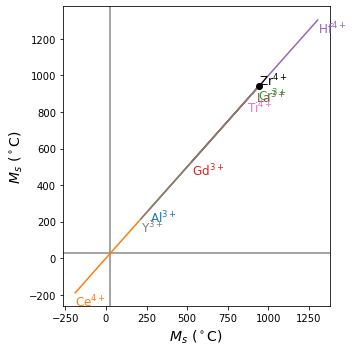

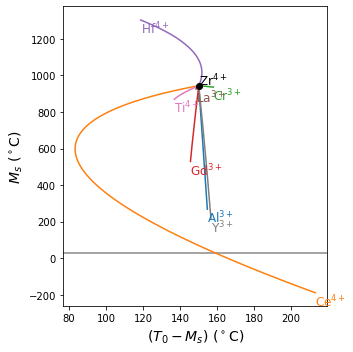

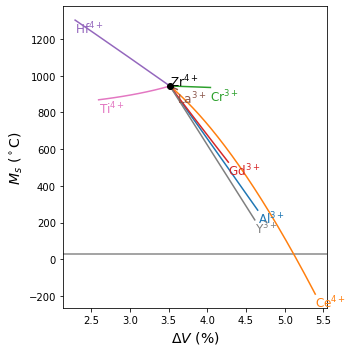

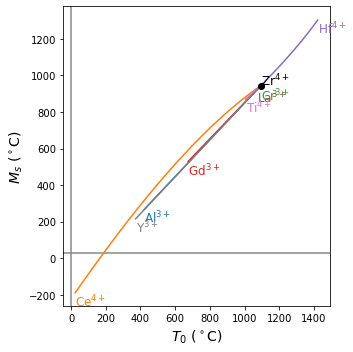

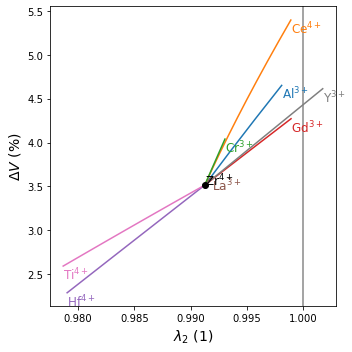

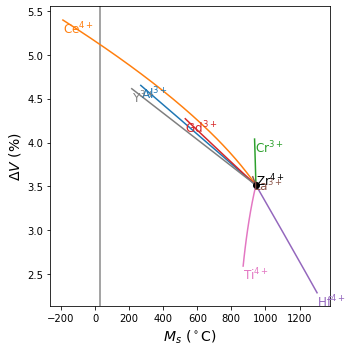

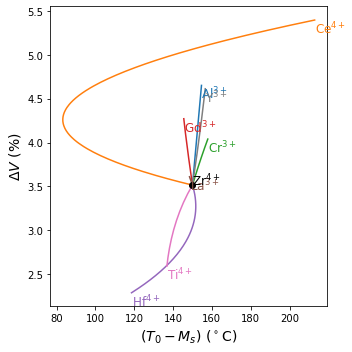

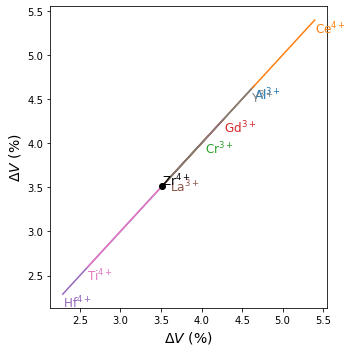

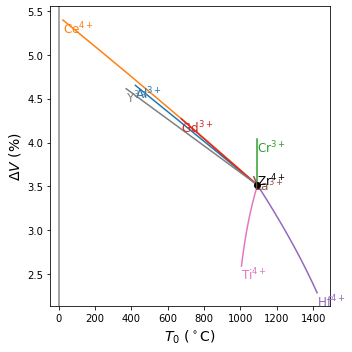

In [9]:
for YAXIS_PROP in ['Ms', 'B_dV']:
    yprop = properties.loc[YAXIS_PROP]

    path = 'data/t0_corr'
    for prop, xprop in properties.iterrows():

        files = sorted([f for f in os.listdir(path) if f.endswith('csv')])
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

        for file in files:
            element = file.strip('.csv')
            df = pd.read_csv(os.path.join(path, file))
            X = features_from_df(df, element)
            results = get_cofactors(X, model)
            results = results.sort_values(element)

            el_labels = elements.loc[element]
            results = results[results[element] < (el_labels['solubility'] / 100)]

            p, = ax.plot(results[prop], results[YAXIS_PROP], label=element)
            ax.annotate(
                el_labels['label'],
                (results[prop].values[-1], results[YAXIS_PROP].values[-1]),
                fontsize=12,
                va='top',
                color=p.get_color()
            )

        ax.scatter([results[prop].values[0]], [results[YAXIS_PROP].values[0]], zorder=3, color='k')
        ax.annotate(
            elements.loc['Zr', 'label'], 
            (results[prop].values[0], results[YAXIS_PROP].values[0]),
            fontsize=12,
        )

        ax.set_xlabel('$%s$ (%s)' % (xprop['label'], xprop['unit']), fontsize=14)
        ax.set_ylabel('$%s$ (%s)' % (yprop['label'], yprop['unit']), fontsize=14)

        ylim = ax.get_ylim()
        xlim = ax.get_xlim()

        ax.plot([xprop['target']] * 2, ylim, '#888888', zorder=-1)
        ax.plot(xlim, [yprop['target']] * 2, '#888888', zorder=-1)

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

        fig.tight_layout()
        fig.savefig(f'figs/{YAXIS_PROP}_{prop}.pdf')
        plt.show()

## correspondence A/C

In [10]:
properties

,label,unit,target
property,,,
B_lambda,\lambda_2,1,1
Ms,M_s,$^\circ$C,27
hyst,(T_0 - M_s),$^\circ$C,0
B_dV,\Delta V,%,0
T,T_0,$^\circ$C,0


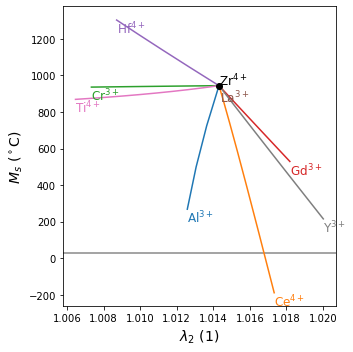

In [13]:
for YAXIS_PROP in ['Ms']:
    yprop = properties.loc[YAXIS_PROP]

    path = 'data/t0_corr'
    prop = 'A_lambda'
    xprop = properties.loc['B_lambda']
    

    files = sorted([f for f in os.listdir(path) if f.endswith('csv')])
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    for file in files:
        element = file.strip('.csv')
        df = pd.read_csv(os.path.join(path, file))
        X = features_from_df(df, element)
        results = get_cofactors(X, model)
        results = results.sort_values(element)

        el_labels = elements.loc[element]
        results = results[results[element] < (el_labels['solubility'] / 100)]

        p, = ax.plot(results[prop], results[YAXIS_PROP], label=element)
        ax.annotate(
            el_labels['label'],
            (results[prop].values[-1], results[YAXIS_PROP].values[-1]),
            fontsize=12,
            va='top',
            color=p.get_color()
        )

    ax.scatter([results[prop].values[0]], [results[YAXIS_PROP].values[0]], zorder=3, color='k')
    ax.annotate(
        elements.loc['Zr', 'label'], 
        (results[prop].values[0], results[YAXIS_PROP].values[0]),
        fontsize=12,
    )

    ax.set_xlabel('$%s$ (%s)' % (xprop['label'], xprop['unit']), fontsize=14)
    ax.set_ylabel('$%s$ (%s)' % (yprop['label'], yprop['unit']), fontsize=14)

    ylim = ax.get_ylim()
    xlim = ax.get_xlim()

    ax.plot([xprop['target']] * 2, ylim, '#888888', zorder=-1)
    ax.plot(xlim, [yprop['target']] * 2, '#888888', zorder=-1)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    fig.tight_layout()
    fig.savefig(f'figs/{YAXIS_PROP}_{prop}.pdf')
    plt.show()

In [19]:
results

,ea,valence,rad_clementi,rad_slater,en_p,Y_Ta,Zr,T,Ms,hyst,A_lambda,B_lambda,C_lambda,A_dV,B_dV,C_dV
0,0.426000,4.0,2.06,1.550000,1.330000,0.000000,1.000000,1094.000000,944.000000,150.000000,1.014314,0.991268,1.014314,3.515514,3.515514,3.515514
1,0.425761,4.0,2.06,1.550161,1.330064,0.002143,0.997857,1093.456960,940.356438,153.100521,1.014310,0.991227,1.014310,3.512637,3.512637,3.512637
2,0.425522,4.0,2.06,1.550321,1.330129,0.004286,0.995714,1092.913919,936.712876,156.201043,1.014306,0.991186,1.014306,3.509760,3.509760,3.509760
3,0.425283,4.0,2.06,1.550482,1.330193,0.006429,0.993571,1092.370879,933.069315,159.301564,1.014301,0.991144,1.014301,3.506884,3.506884,3.506884
4,0.425044,4.0,2.06,1.550643,1.330257,0.008571,0.991429,1091.827839,929.425753,162.402086,1.014297,0.991103,1.014297,3.504007,3.504007,3.504007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,0.403063,4.0,2.06,1.565429,1.336171,0.205714,0.794286,596.006030,433.210426,162.795604,1.017686,0.992181,1.017686,3.710147,3.710147,3.710147
102,0.402824,4.0,2.06,1.565589,1.336236,0.207857,0.792143,589.914944,424.466354,165.448589,1.017728,0.992201,1.017728,3.713124,3.713124,3.713124
103,0.402585,4.0,2.06,1.565750,1.336300,0.210000,0.790000,583.823857,415.722283,168.101574,1.017771,0.992220,1.017771,3.716102,3.716102,3.716102
104,0.402346,4.0,2.06,1.565911,1.336364,0.212143,0.787857,577.732771,406.978212,170.754559,1.017814,0.992240,1.017814,3.719079,3.719079,3.719079


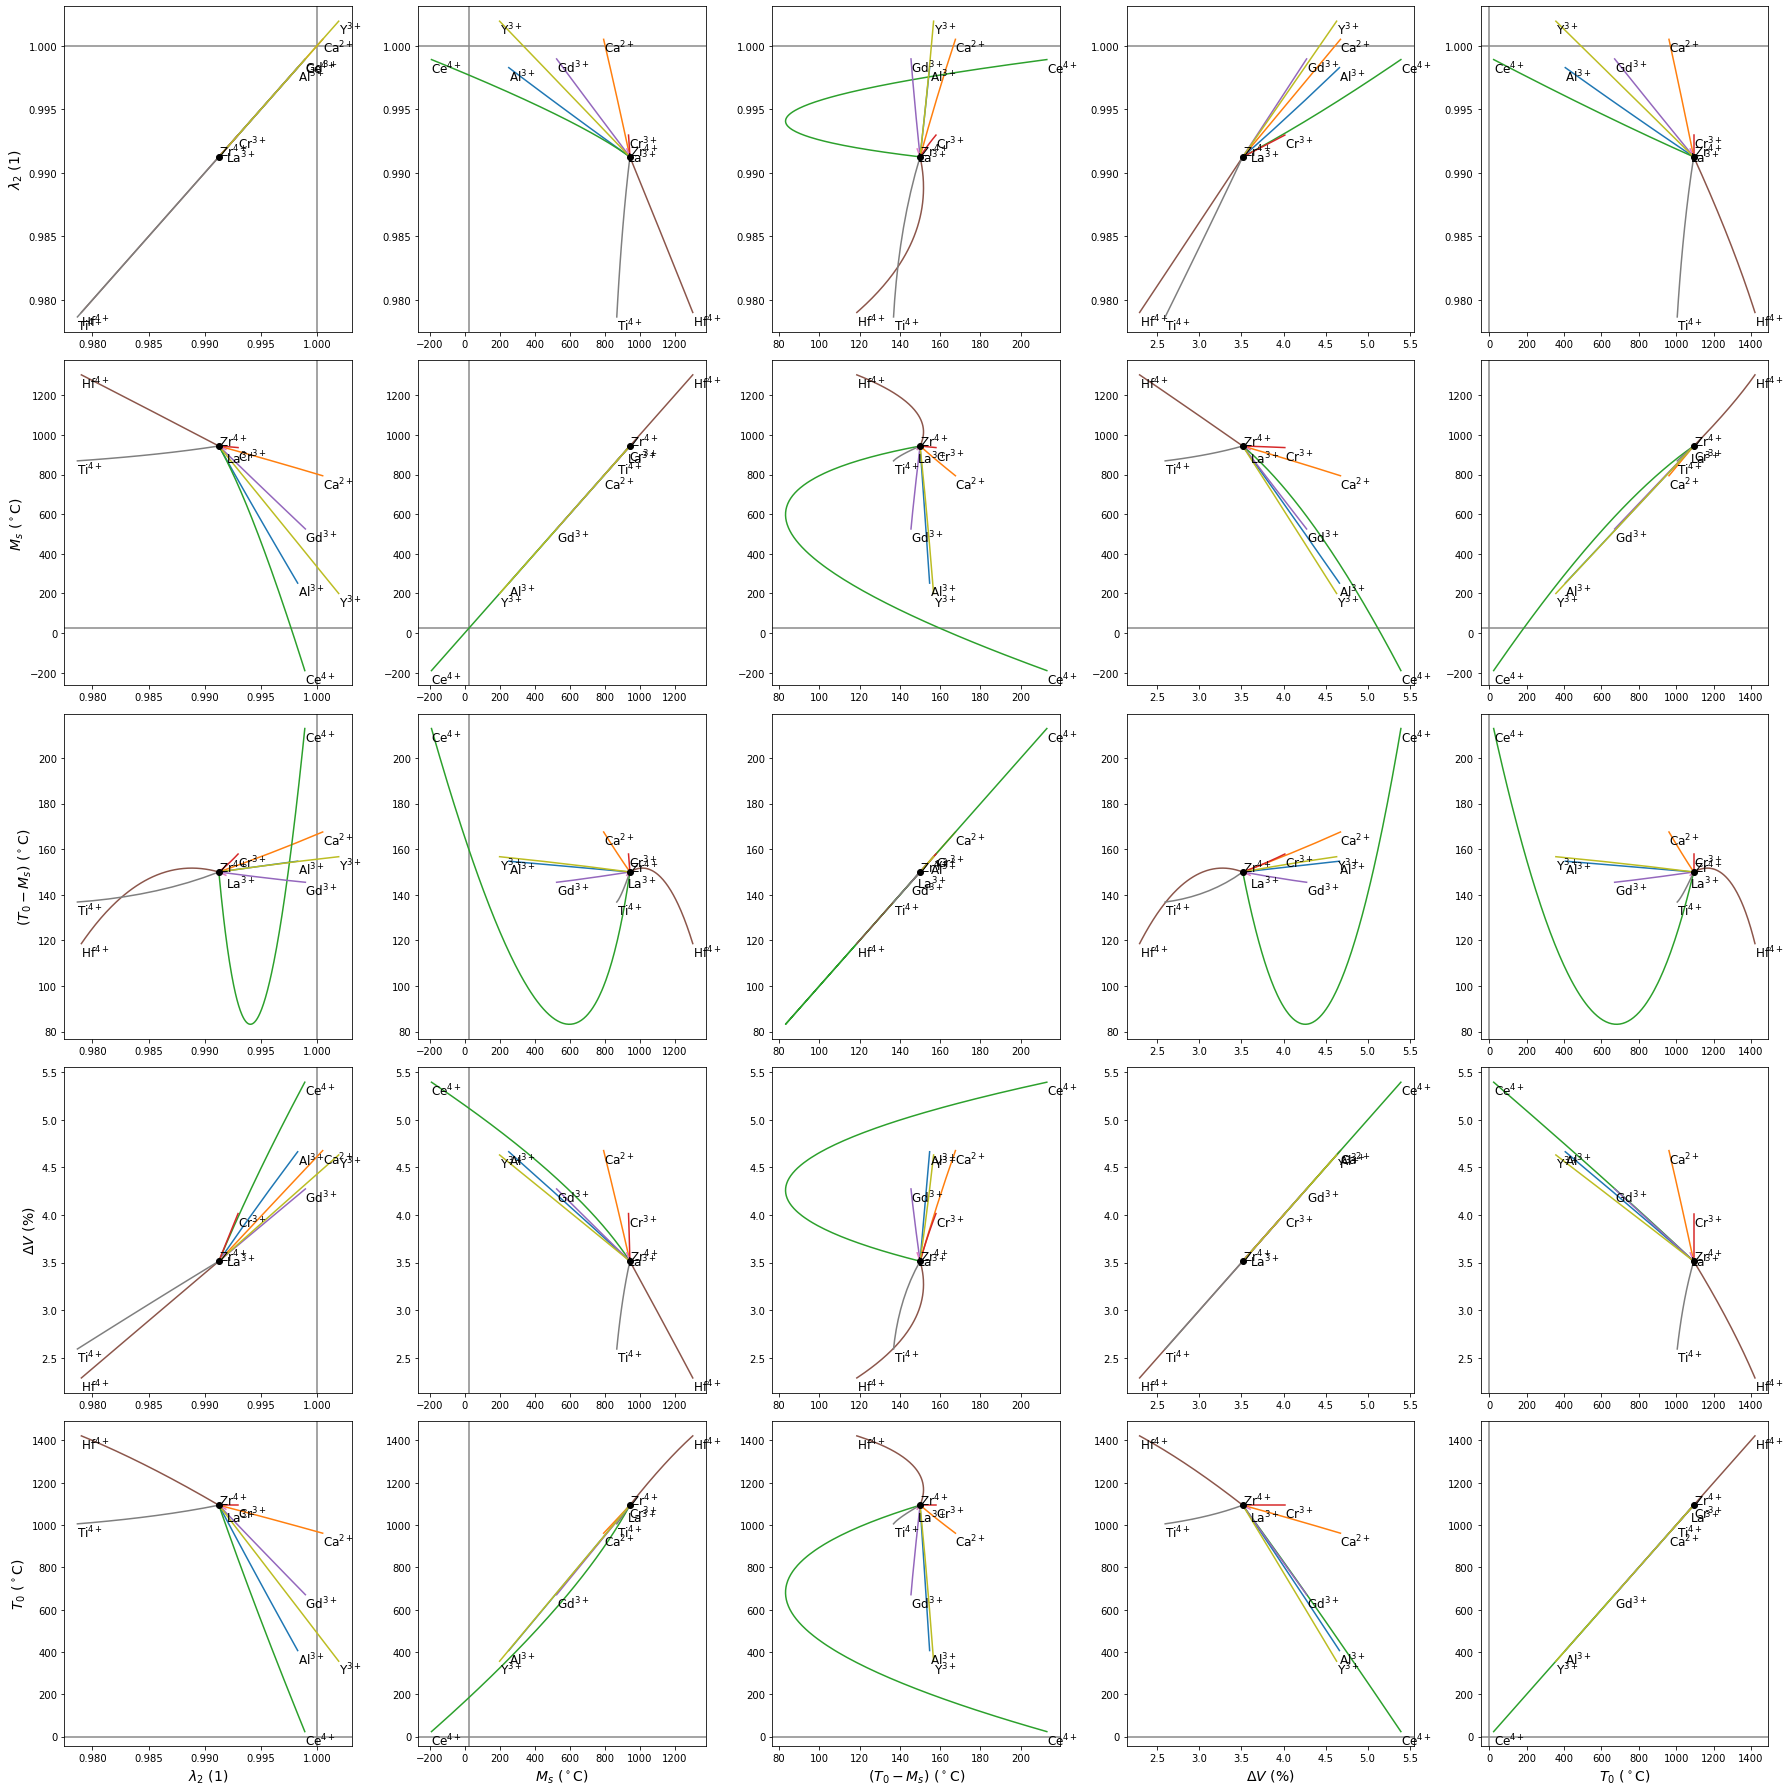

In [106]:
N = len(properties)
fig, ax_fig = plt.subplots(N, N, figsize=(5 * N, 5 * N))
path = 'data/t0_corr'

for ix, (YAXIS_PROP, yprop) in enumerate(properties.iterrows()):

    for iy, (prop, xprop) in enumerate(properties.iterrows()):
        ax = ax_fig[ix, iy]

        files = sorted(os.listdir(path))

        for file in files:
            element = file.strip('.csv')
            df = pd.read_csv(os.path.join(path, file))
            X = features_from_df(df, element)
            results = get_cofactors(X, model)
            results = results.sort_values(element)

            el_labels = elements.loc[element]
            results = results[results[element] < (el_labels['solubility'] / 100)]

            ax.plot(results[prop], results[YAXIS_PROP], label=element)
            ax.annotate(el_labels['label'], (results[prop].values[-1], results[YAXIS_PROP].values[-1]), fontsize=12, va='top')

        ax.scatter([results[prop].values[0]], [results[YAXIS_PROP].values[0]], zorder=3, color='k')
        ax.annotate(elements.loc['Zr', 'label'], (results[prop].values[0], results[YAXIS_PROP].values[0]), fontsize=12)

        if ix == N - 1:
            ax.set_xlabel('$%s$ (%s)' % (xprop['label'], xprop['unit']), fontsize=14)
#         else:
#             ax.set_xticks([])
        
        if iy == 0:
            ax.set_ylabel('$%s$ (%s)' % (yprop['label'], yprop['unit']), fontsize=14)
#         else:
#             ax.set_yticks([])

        ylim = ax.get_ylim()
        xlim = ax.get_xlim()
        
        ax.plot([xprop['target']] * 2, ylim, '#888888', zorder=-1)
        ax.plot(xlim, [yprop['target']] * 2, '#888888', zorder=-1)
        
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        
    #     ax.set_ylim(ylim)

#         ax.spines['top'].set_visible(False)
#         ax.spines['right'].set_visible(False)
#         ax.spines['left'].set_position(('data', xprop['target']))
#         ax.spines['bottom'].set_position(('data', yprop['target']))
    #     ax.plot([1, 1], ylim, color='#808080', zorder=-1)

fig.tight_layout()
fig.savefig('figs/binary_summary.pdf')
plt.show()

### Elemental properties

In [9]:
COLOR_LABEL = {
    'T': "#d62728",
    'Ms': "#ff7f0e",
    'B_lambda': "#2ca02c",
    'B_dV': "#1f77b4"
}

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)


def plot_props(df, element):
    fig, host = plt.subplots()
    fig.subplots_adjust(right=0.75)

    par1 = host.twinx()
    par2 = host.twinx()

    # Offset the right spine of par2.  The ticks and label have already been
    # placed on the right by twinx above.
    par2.spines["right"].set_position(("axes", 1.3))
    # Having been created by twinx, par2 has its frame off, so the line of its
    # detached spine is invisible.  First, activate the frame but make the patch
    # and spines invisible.
    make_patch_spines_invisible(par2)
    # Second, show the right spine.
    par2.spines["right"].set_visible(True)

    x = df[element] * 100
    p1, = host.plot(x, df['T'], color=COLOR_LABEL['T'], label="T0")    
    p1_2, = host.plot(x, df['Ms'], color=COLOR_LABEL['Ms'], label="Ms")
    
    host.annotate(r'$T_0$', (x[0], df['T'][0]),
                  ha='left', va='center',
                  color=p1.get_color(),
                  fontsize=10,
                  backgroundcolor='#ffffff80')

    host.annotate(r'$M_s$', (x[0], df['Ms'][0]),
                  ha='left', va='center',
                  color=p1_2.get_color(),
                  fontsize=10,
                  backgroundcolor='#ffffff80')
    
    p2, = par1.plot(x, df['B_lambda'], color=COLOR_LABEL['B_lambda'])
    p3, = par2.plot(x, df['B_dV'], linestyle='--', color=COLOR_LABEL['B_dV'])

#     host.set_xlim(0, 2)
#     host.set_ylim(0, 2)
#     par1.set_ylim(0, 4)
#     par2.set_ylim(1, 65)

    host.set_xlabel('%s (mol %%)' % ELEMENT_STR.get(element, element), fontsize=12)
    host.set_ylabel(r'Temperature ($^\circ$C)', fontsize=12)
    par1.set_ylabel(r'$\lambda_2$', fontsize=12)
    par2.set_ylabel(r'$\Delta V$ (%)', fontsize=12)

    host.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p2.get_color())
    par2.yaxis.label.set_color(p3.get_color())

    tkw = dict(size=4, width=1.5)
    host.tick_params(axis='y', colors=p1.get_color(), **tkw)
    par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
    par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
    host.tick_params(axis='x', **tkw)

    lines = [p1, p1_2]

#     host.legend(lines, [l.get_label() for l in lines])
    
    fig.tight_layout()
    plt.show()

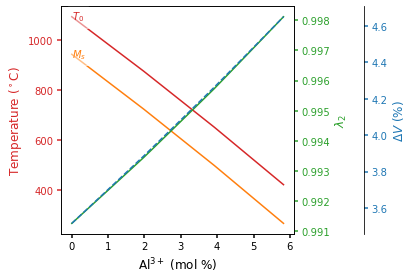

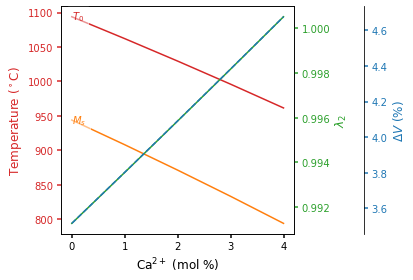

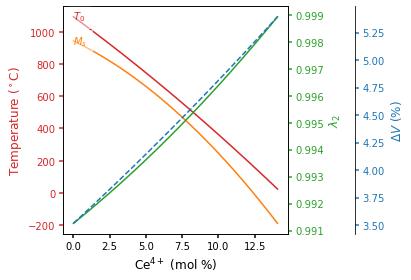

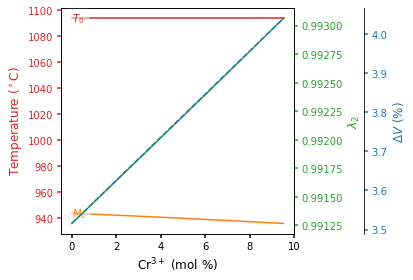

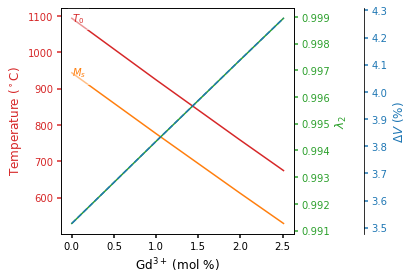

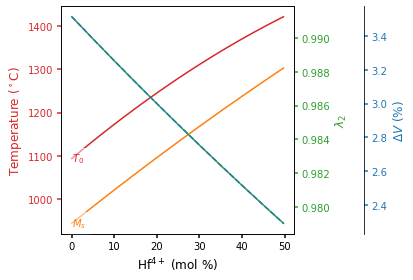

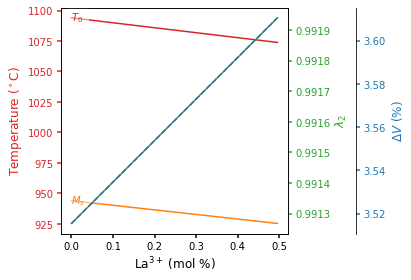

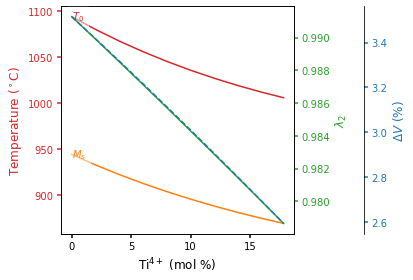

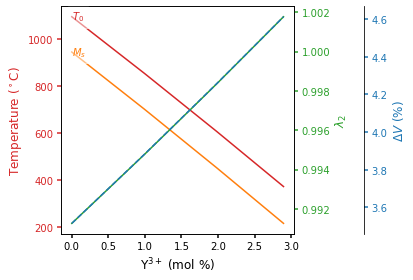

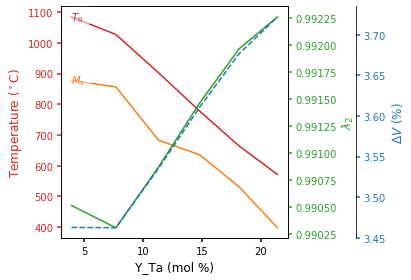

In [10]:
files = sorted(os.listdir('data/t0'))

for file in files:
    element = file.strip('.csv')
    df = pd.read_csv(os.path.join('data/t0', file))
    X = features_from_df(df, element, n_samples=101)
    results = get_cofactors(X, model)
    results = results.sort_values(element)
    
    el_labels = elements.loc[element]
    results = results[results[element] < (el_labels['solubility'] / 100)]

    plot_props(results, element)


### Corrected data

In [11]:
def features_from_corrected_df(df, element):
    df['T0'] = df['T0 (C, corr)']
    df['Ms'] = df['Ms (K)'] - 273
    df['x'] = to_mol_percent(df, element)
    
    inputs = {
        element: df.x.values.reshape(-1, 1),
        'Zr': 1 - df.x.values.reshape(-1, 1),
        'T': df.T0.values.reshape(-1, 1),
        'Ms': df.Ms.values.reshape(-1, 1),
        'hyst': (df.T0 - df.Ms).values.reshape(-1, 1),
    }
    
    if 'Af (C, expt)' in df.columns:
        inputs['Af'] = df['Af (C, expt)'].values.reshape(-1, 1)

    X = featgen.get_features(inputs, model.features)
    
    return X

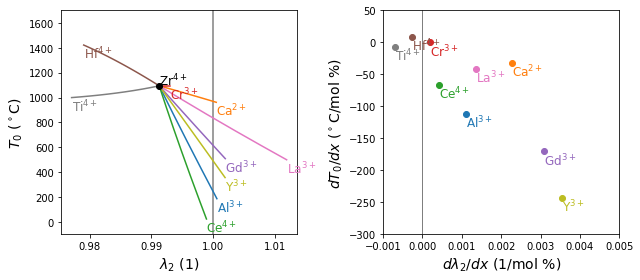

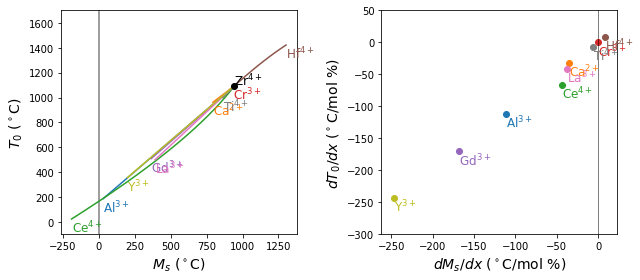

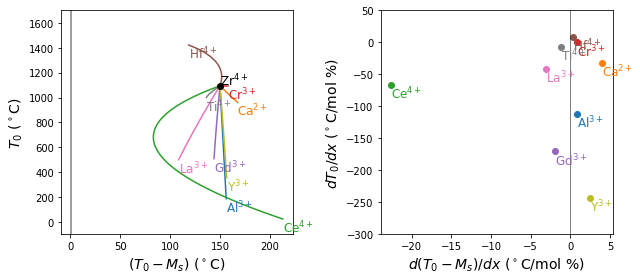

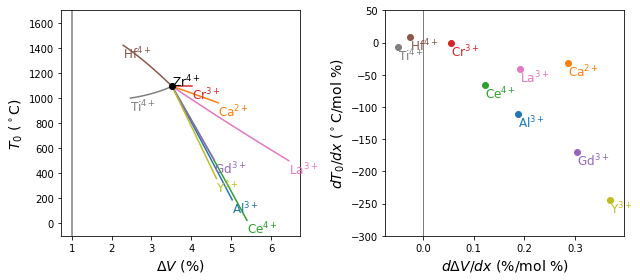

In [31]:
path = 'data/t0_corr'
for prop in PROP_LABEL.keys():
    files = sorted(os.listdir(path))
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))

    for file in files:
        element = file.strip('.csv')
        df = pd.read_csv(os.path.join(path, file))
        X = features_from_df(df, element)
        results = get_cofactors(X, model)
        results = results.sort_values(element)

        p, = ax[0].plot(results[prop], results['T'], label=element)
#         ax[0].fill_betweenx(
#             results['T'],
#             results[prop] - UNCERTAINTY_LAMBDA,
#             results[prop] + UNCERTAINTY_LAMBDA,
#             alpha=0.2
#         )
        ax[0].annotate(
            ELEMENT_STR[element],
            (results[prop].values[-1], results['T'].values[-1]),
            fontsize=12,
            va='top',
            color=p.get_color()
        )

        dT, dL = get_gradient(results, element, prop)
        ax[1].scatter(dL, dT)
        ax[1].annotate(
            ELEMENT_STR[element],
            (dL, dT),
            fontsize=12,
            va='top',
            color=p.get_color(),
#             path_effects=[pe.withStroke(linewidth=0.2, foreground="k")]
        )

    ax[0].scatter([results[prop].values[0]], [results['T'].values[0]], zorder=3, color='k')
    ax[0].annotate(ELEMENT_STR['Zr'], (results[prop].values[0], results['T'].values[0]), fontsize=12)

    ax[0].set_xlabel('$%s$ (%s)' % (PROP_LABEL[prop], PROP_UNIT[prop]), fontsize=14)
    ax[0].set_ylabel(r'$T_0$ ($^\circ$C)', fontsize=14)

    ylim = (-100, 1700)
    ax[0].set_ylim(ylim)
    ax[0].plot([1, 1], ylim, color='#808080', zorder=-1)

    ax[1].set_xlabel('$d%s/dx$ (%s/mol %%)' % (PROP_LABEL[prop], PROP_UNIT[prop]), fontsize=14)
    ax[1].set_ylabel(r'$dT_0/dx$ ($^\circ$C/mol %)', fontsize=14)

    ylim1 = [-300, 50]
    ax[1].plot([0, 0], ylim1, color='k', linewidth=0.5)
    ax[1].set_ylim(ylim1)
    
    if prop == 'B_lambda':
        ax[1].set_xlim(-0.001, 0.005)
    
    # ax.legend()
    fig.tight_layout()
    
    fig.savefig('figs/binary_T_%s.pdf' % prop)
    plt.show()

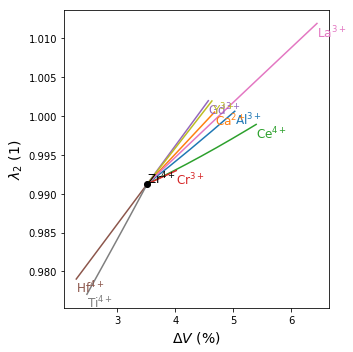

In [34]:
prop = 'B_dV'
prop_y = 'B_lambda'

files = sorted(os.listdir('data/t0_corr'))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for file in files:
    element = file.strip('.csv')
    df = pd.read_csv(os.path.join('data/t0_corr', file))
    X = features_from_df(df, element)
    results = get_cofactors(X, model)
    results = results.sort_values(element)

    p, = ax.plot(results[prop], results[prop_y], label=element)
#         ax[0].fill_betweenx(
#             results[prop_y],
#             results[prop] - UNCERTAINTY_LAMBDA,
#             results[prop] + UNCERTAINTY_LAMBDA,
#             alpha=0.2
#         )
    ax.annotate(
        ELEMENT_STR[element],
        (results[prop].values[-1], results[prop_y].values[-1]),
        fontsize=12,
        va='top',
        color=p.get_color()
    )

    dT, dL = get_gradient(results, element, prop)

ax.scatter([results[prop].values[0]], [results[prop_y].values[0]], zorder=3, color='k')
ax.annotate(ELEMENT_STR['Zr'], (results[prop].values[0], results[prop_y].values[0]), fontsize=12)

ax.set_xlabel('$%s$ (%s)' % (PROP_LABEL[prop], PROP_UNIT[prop]), fontsize=14)
ax.set_ylabel('$%s$ (%s)' % (PROP_LABEL[prop_y], PROP_UNIT[prop_y]), fontsize=14)

# ax.legend()
fig.tight_layout()
fig.savefig('figs/lambda_dV.pdf')
plt.show()

In [13]:
def plot_props_with_corr(df, corr_df, element):
    fig, host = plt.subplots()
    fig.subplots_adjust(right=0.75)

    par1 = host.twinx()
    par2 = host.twinx()

    # Offset the right spine of par2.  The ticks and label have already been
    # placed on the right by twinx above.
    par2.spines["right"].set_position(("axes", 1.3))
    # Having been created by twinx, par2 has its frame off, so the line of its
    # detached spine is invisible.  First, activate the frame but make the patch
    # and spines invisible.
    make_patch_spines_invisible(par2)
    # Second, show the right spine.
    par2.spines["right"].set_visible(True)

    x = df[element] * 100
    p1, = host.plot(x, df['T'], color=COLOR_LABEL['T'], label="T0")    
    p1_2, = host.plot(x, df['Ms'], color=COLOR_LABEL['Ms'], label="Ms")
    
    host.annotate(r'$T_0$', (x[0], df['T'][0]),
                  ha='left', va='center',
                  color=p1.get_color(),
                  fontsize=10,
                  backgroundcolor='#ffffff80')

    host.annotate(r'$M_s$', (x[0], df['Ms'][0]),
                  ha='left', va='center',
                  color=p1_2.get_color(),
                  fontsize=10,
                  backgroundcolor='#ffffff80')
    
    p1, = host.plot(x, corr_df['T'], color=COLOR_LABEL['T'], linestyle='--', label="T0")    
    
    host.annotate(r'$T_0$ (corr)', (x[0], corr_df['T'][0]),
                  ha='left', va='center',
                  color=p1.get_color(),
                  fontsize=10,
                  backgroundcolor='#ffffff80')
    
    p2, = par1.plot(x, df['B_lambda'], color=COLOR_LABEL['B_lambda'])
    p3, = par2.plot(x, df['B_dV'], color=COLOR_LABEL['B_dV'])
    
    p2, = par1.plot(x, corr_df['B_lambda'], linestyle='--', color=COLOR_LABEL['B_lambda'])
    p3, = par2.plot(x, corr_df['B_dV'], linestyle='--', color=COLOR_LABEL['B_dV'])

#     host.set_xlim(0, 2)
#     host.set_ylim(0, 2)
#     par1.set_ylim(0, 4)
#     par2.set_ylim(1, 65)

    host.set_xlabel('%s (mol %%)' % ELEMENT_STR.get(element, element), fontsize=12)
    host.set_ylabel(r'Temperature ($^\circ$C)', fontsize=12)
    par1.set_ylabel(r'$\lambda_2$', fontsize=12)
    par2.set_ylabel(r'$\Delta V$ (%)', fontsize=12)

    host.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p2.get_color())
    par2.yaxis.label.set_color(p3.get_color())

    tkw = dict(size=4, width=1.5)
    host.tick_params(axis='y', colors=p1.get_color(), **tkw)
    par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
    par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
    host.tick_params(axis='x', **tkw)

    lines = [p1, p1_2]

#     host.legend(lines, [l.get_label() for l in lines])
    
    fig.tight_layout()

    plt.show()

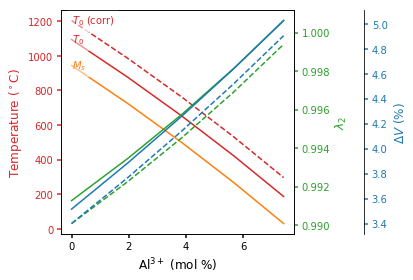

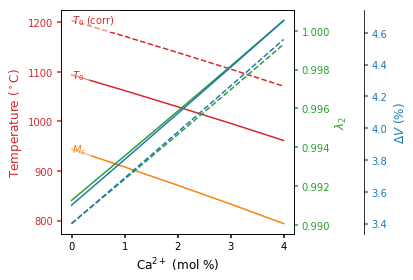

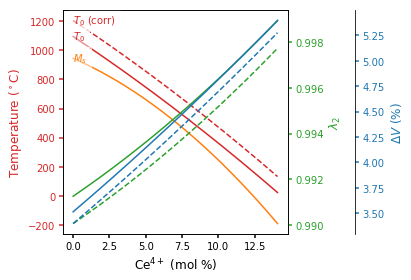

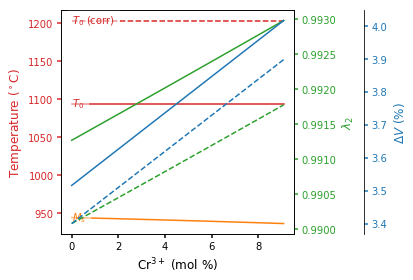

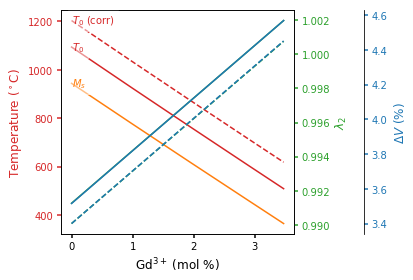

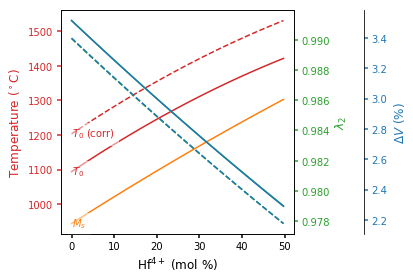

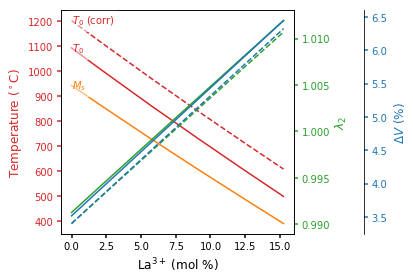

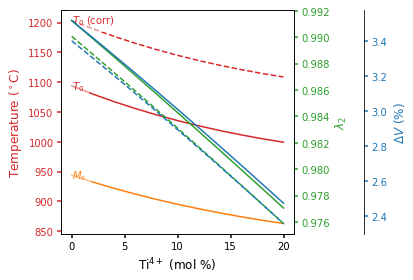

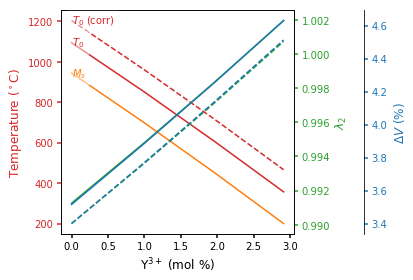

In [14]:
files = sorted(os.listdir('data/t0'))
corr_files = sorted(os.listdir('data/t0_corr'))

for file, cfile in zip(files, corr_files):
    element = file.strip('.csv')
    df = pd.read_csv(os.path.join('data/t0', file))
    df_corr = pd.read_csv(os.path.join('data/t0_corr', cfile))
    
    X = features_from_df(df, element)
    results = get_cofactors(X, model)
    results = results.sort_values(element)
    
    corr_X = features_from_corrected_df(df_corr, element)
    corr_results = get_cofactors(corr_X, model)
    corr_results = corr_results.sort_values(element)
    
    plot_props_with_corr(results, corr_results, element)

### For those that also have experimental values:

In [15]:
def features_from_expt_df(df, element):
    df['T0'] = df['Af (C, expt)']
    df['Ms'] = df['Ms (K)'] - 273
    df['x'] = to_mol_percent(df, element)
    
    inputs = {
        element: df.x.values.reshape(-1, 1),
        'Zr': 1 - df.x.values.reshape(-1, 1),
        'T': df.T0.values.reshape(-1, 1),
        'Ms': df.Ms.values.reshape(-1, 1),
        'hyst': (df.T0 - df.Ms).values.reshape(-1, 1),
    }
    
    X = featgen.get_features(inputs, model.features)
    
    return X

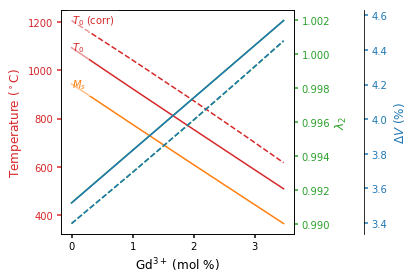

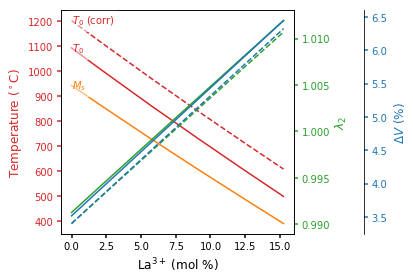

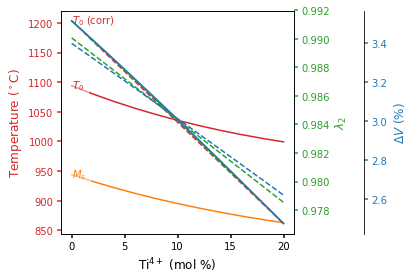

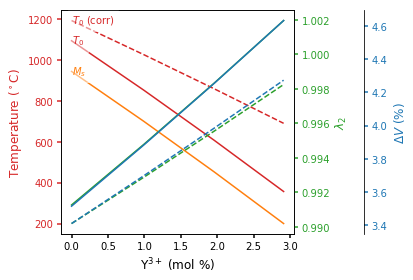

In [16]:
files = sorted(os.listdir('data/t0'))
corr_files = sorted(os.listdir('data/t0_corr'))

for file, cfile in zip(files, corr_files):
    element = file.strip('.csv')
    
    if element in ['Gd', 'La', 'Ti', 'Y']:
        df = pd.read_csv(os.path.join('data/t0', file))
        df_corr = pd.read_csv(os.path.join('data/t0_corr', cfile))

        X = features_from_df(df, element)
        results = get_cofactors(X, model)
        results = results.sort_values(element)

        corr_X = features_from_expt_df(df_corr, element)
        corr_results = get_cofactors(corr_X, model)
        corr_results = corr_results.sort_values(element)

        plot_props_with_corr(results, corr_results, element)